In [ ]:
# AJUSTE DOS PATHS PARA OS ARQUIVOS DE DADOS
path_dim_customer = "./data/DIM_Customer.csv"
path_dim_products = "./data/DIM_Products.csv"
path_dim_delivery = "./data/DIM_Delivery.csv"
path_fact_orders = "./data/FACT_Orders.csv"
path_dim_shopping = "./data/DIM_Shopping.csv"


# %% [markdown]
# # Análise de Dados - E-commerce (Brasil)
# 
# Pipeline completo:
# - Carregamento e preparação dos dados
# - Feature Engineering
# - Análise exploratória (EDA) com gráficos
# - KPIs
# - Inferência Estatística

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

 ## Ajustar diretório raiz do projeto

In [ ]:
# 🔥 Ajustar diretório raiz do projeto (ESSENCIAL para caminhos relativos)
os.chdir(r"C:\Users\rafaf\OneDrive\Desktop\ecommerce-data-analytics-pipeline")
print("Diretório atual:", os.getcwd())

# Configurações gerais
pd.set_option("display.max_columns", 50)
plt.style.use("default")

# Criar pastas de saída se não existirem
os.makedirs("./kpis", exist_ok=True)
os.makedirs("./images", exist_ok=True)

Diretório atual: C:\Users\rafaf\OneDrive\Desktop\ecommerce-data-analytics-pipeline


 ## 1. Carregamento dos dados

In [ ]:
# Caminhos dos arquivos na pasta ./data/
path_dim_customer = "./data/DIM_Customer.csv"
path_dim_products = "./data/DIM_Products.csv"
path_dim_delivery = "./data/DIM_Delivery.csv"
path_fact_orders = "./data/FACT_Orders.csv"
path_dim_shopping = "./data/DIM_Shopping.csv"

# Carregar os CSVs
dim_customer = pd.read_csv(path_dim_customer)
dim_products = pd.read_csv(path_dim_products)
dim_delivery = pd.read_csv(path_dim_delivery)
fact_orders = pd.read_csv(path_fact_orders)
dim_shopping = pd.read_csv(path_dim_shopping)

dim_customer.head()

,Id,Customer_Id,Customer_Name,City,State,Region
0,1,C00001,Catarina Oliveira,Sena Madureira,AC,Norte
1,2,C00002,Igor Cunha,Campina Grande,PB,Nordeste
2,3,C00003,Isis Barbosa,Cantá,RR,Norte
3,4,C00004,Evelyn da Luz,Cacoal,RO,Norte
4,5,C00005,Sra. Lara Costela,Rio Branco,AC,Norte


 ## 2. Qualidade dos dados & tipos

In [ ]:
def resumo_qualidade(df, nome):
    print(f"\n===== {nome} =====")
    print("Shape:", df.shape)
    print("\nTipos:")
    print(df.dtypes)
    print("\nNulos por coluna:")
    print(df.isna().sum())

for nome, df in [
    ("DIM_Customer", dim_customer),
    ("DIM_Products", dim_products),
    ("DIM_Delivery", dim_delivery),
    ("FACT_Orders", fact_orders),
    ("DIM_Shopping", dim_shopping),
]:
    resumo_qualidade(df, nome)


===== DIM_Customer =====
Shape: (2000, 6)

Tipos:
Id                int64
Customer_Id      object
Customer_Name    object
City             object
State            object
Region           object
dtype: object

Nulos por coluna:
Id               0
Customer_Id      0
Customer_Name    0
City             0
State            0
Region           0
dtype: int64

===== DIM_Products =====
Shape: (21, 6)

Tipos:
Id                int64
Product_Id       object
Product_Name     object
Category         object
Subcategory      object
Price           float64
dtype: object

Nulos por coluna:
Id              0
Product_Id      0
Product_Name    0
Category        0
Subcategory     0
Price           0
dtype: int64

===== DIM_Delivery =====
Shape: (2000, 7)

Tipos:
Id               int64
Delivery_Id     object
Services        object
P_Sevice       float64
D_Forecast      object
D_Date          object
Status          object
dtype: object

Nulos por coluna:
Id             0
Delivery_Id    0
Services       0
P_

 ## 3. Conversão de tipos e joins

In [ ]:
fact_orders["Order_Date"] = pd.to_datetime(fact_orders["Order_Date"])
dim_delivery["D_Date"] = pd.to_datetime(dim_delivery["D_Date"])
dim_delivery["D_Forecast"] = pd.to_datetime(dim_delivery["D_Forecast"])

df = (
    fact_orders
    .merge(dim_delivery, on="Id", how="left", suffixes=("", "_deliv"))
    .merge(dim_customer[["Id", "Customer_Id", "State", "Region"]], on="Id", how="left")
)

df.head()

,Id,Order_Date,Discount,Subtotal,Total,payment,Purchase_Status,Delivery_Id,Services,P_Sevice,D_Forecast,D_Date,Status,Customer_Id,State,Region
0,1,2025-04-12 00:52:33,0.1048,3958.20,3586.28,Credito,Processando,D00001,Same-Day,42.9,2025-05-03 14:45:17,2025-05-03 14:45:17,A Caminho,C00001,AC,Norte
1,2,2025-05-05 01:02:38,0.1141,1799.01,1636.64,PIX,Em Analise,D00002,Same-Day,42.9,2025-05-14 07:31:07,2025-05-17 07:31:07,Entregue,C00002,PB,Nordeste
2,3,2025-04-27 23:05:38,0.0686,2144.00,2019.82,Boleto,Cancelado,D00003,Standard,22.9,2025-05-10 15:29:43,2025-05-10 15:29:43,A Caminho,C00003,RR,Norte
3,4,2025-04-10 02:42:52,0.0264,199.60,237.23,Debito,Processando,D00004,Same-Day,42.9,2025-05-07 16:01:14,2025-05-10 16:01:14,Entregue,C00004,RO,Norte
4,5,2025-05-12 21:55:33,0.0697,161.70,193.33,Credito,Em Analise,D00005,Same-Day,42.9,2025-04-30 15:40:39,2025-05-04 15:40:39,Entregue,C00005,AC,Norte


 ## 4. Feature Engineering

In [ ]:
df["delivery_delay_days"] = (df["D_Date"] - df["D_Forecast"]).dt.days
df["delivery_lead_time"] = (df["D_Date"] - df["Order_Date"]).dt.days
df["is_late"] = (df["D_Date"] > df["D_Forecast"]).astype(int)
df["is_confirmed"] = (df["Purchase_Status"] == "Confirmado").astype(int)
df["freight_share"] = df["P_Sevice"] / df["Total"]
df["discount_abs"] = df["Discount"] * df["Subtotal"]
df["month"] = df["Order_Date"].dt.to_period("M").astype(str)

df.head()

,Id,Order_Date,Discount,Subtotal,Total,payment,Purchase_Status,Delivery_Id,Services,P_Sevice,D_Forecast,D_Date,Status,Customer_Id,State,Region,delivery_delay_days,delivery_lead_time,is_late,is_confirmed,freight_share,discount_abs,month
0,1,2025-04-12 00:52:33,0.1048,3958.20,3586.28,Credito,Processando,D00001,Same-Day,42.9,2025-05-03 14:45:17,2025-05-03 14:45:17,A Caminho,C00001,AC,Norte,0,21,0,0,0.011962,414.819360,2025-04
1,2,2025-05-05 01:02:38,0.1141,1799.01,1636.64,PIX,Em Analise,D00002,Same-Day,42.9,2025-05-14 07:31:07,2025-05-17 07:31:07,Entregue,C00002,PB,Nordeste,3,12,1,0,0.026212,205.267041,2025-05
2,3,2025-04-27 23:05:38,0.0686,2144.00,2019.82,Boleto,Cancelado,D00003,Standard,22.9,2025-05-10 15:29:43,2025-05-10 15:29:43,A Caminho,C00003,RR,Norte,0,12,0,0,0.011338,147.078400,2025-04
3,4,2025-04-10 02:42:52,0.0264,199.60,237.23,Debito,Processando,D00004,Same-Day,42.9,2025-05-07 16:01:14,2025-05-10 16:01:14,Entregue,C00004,RO,Norte,3,30,1,0,0.180837,5.269440,2025-04
4,5,2025-05-12 21:55:33,0.0697,161.70,193.33,Credito,Em Analise,D00005,Same-Day,42.9,2025-04-30 15:40:39,2025-05-04 15:40:39,Entregue,C00005,AC,Norte,4,-9,1,0,0.221900,11.270490,2025-05


 ## 5. Estatísticas descritivas

In [ ]:
print("===== Estatísticas gerais =====")
print(f"Ticket médio: R$ {df['Total'].mean():,.2f}")
print(f"Lead time médio: {df['delivery_lead_time'].mean():.2f} dias")
print(f"Atraso médio: {df['delivery_delay_days'].mean():.2f} dias")
print(f"Proporção atrasados: {df['is_late'].mean():.2%}")
print(f"Cancelamentos: {(df['Purchase_Status']=='Cancelado').mean():.2%}")

===== Estatísticas gerais =====
Ticket médio: R$ 2,502.08
Lead time médio: 30.55 dias
Atraso médio: 2.53 dias
Proporção atrasados: 83.25%
Cancelamentos: 25.80%


 ## 6. EDA – Gráficos

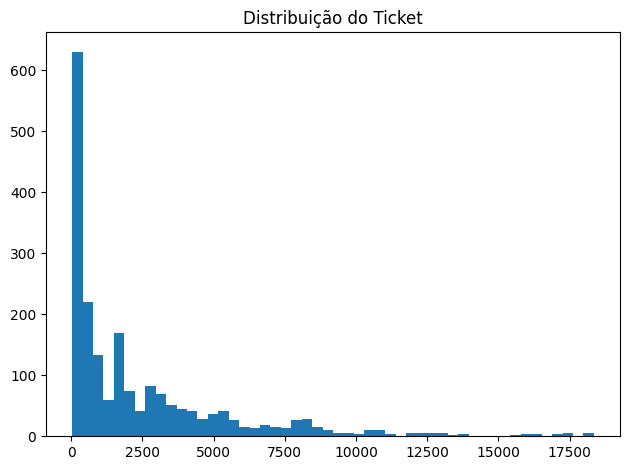

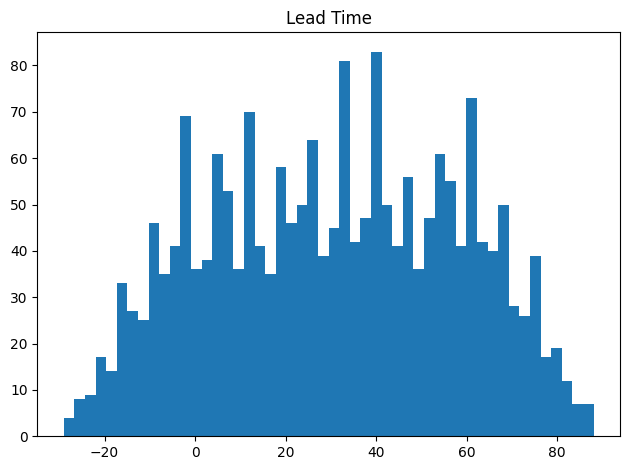

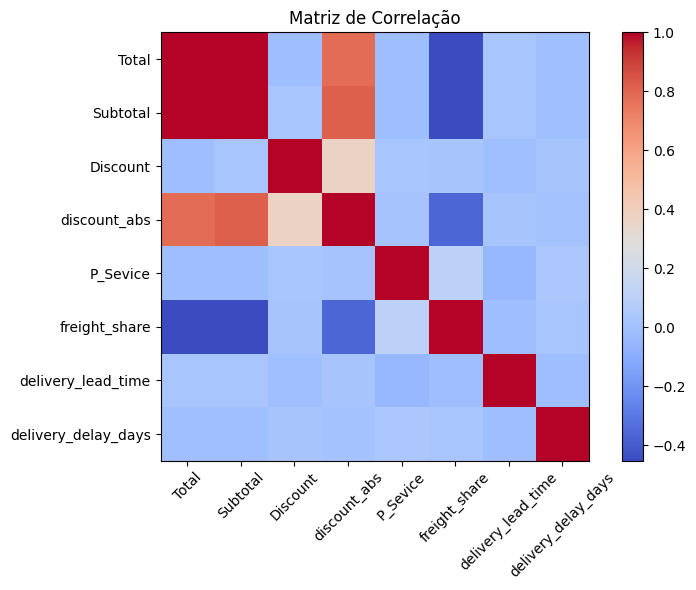

In [ ]:
plt.hist(df["Total"], bins=50)
plt.title("Distribuição do Ticket")
plt.tight_layout()
plt.savefig("./images/hist_ticket.png", dpi=120)
plt.show()

plt.hist(df["delivery_lead_time"], bins=50)
plt.title("Lead Time")
plt.tight_layout()
plt.savefig("./images/hist_leadtime.png", dpi=120)
plt.show()

# Correlação
numeric_cols = [
    "Total","Subtotal","Discount","discount_abs",
    "P_Sevice","freight_share","delivery_lead_time","delivery_delay_days"
]

corr = df[numeric_cols].corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.title("Matriz de Correlação")
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.tight_layout()
plt.savefig("./images/correlacao.png", dpi=120)
plt.show()

 ## 7. KPIs por dimensão

In [ ]:
kpis_by_service = df.groupby("Services").agg(
    orders=("Id","count"),
    avg_ticket=("Total","mean"),
    avg_lead_time=("delivery_lead_time","mean"),
    avg_delay=("delivery_delay_days","mean"),
    late_rate=("is_late","mean"),
    cancel_rate=("Purchase_Status", lambda x:(x=="Cancelado").mean()),
    freight_share_mean=("freight_share","mean")
).reset_index()

kpis_by_payment = df.groupby("payment").agg(
    orders=("Id","count"),
    confirm_rate=("is_confirmed","mean"),
    cancel_rate=("Purchase_Status", lambda x:(x=="Cancelado").mean()),
    avg_ticket=("Total","mean")
).reset_index()

kpis_by_region = df.groupby("Region").agg(
    orders=("Id","count"),
    avg_ticket=("Total","mean"),
    avg_lead_time=("delivery_lead_time","mean"),
    late_rate=("is_late","mean"),
).reset_index()

print(kpis_by_service)
print(kpis_by_payment)
print(kpis_by_region)

    Services  orders   avg_ticket  avg_lead_time  avg_delay  late_rate  \
0   Same-Day     627  2574.487432      28.307815   2.577352   0.840510   
1  Scheduled     686  2280.346618      31.631195   2.604956   0.842566   
2   Standard     687  2657.418821      31.508006   2.413392   0.815138   

   cancel_rate  freight_share_mean  
0     0.267943            0.108385  
1     0.266764            0.096375  
2     0.240175            0.071145  
   payment  orders  confirm_rate  cancel_rate   avg_ticket
0   Boleto     510      0.231373     0.268627  2441.596549
1  Credito     488      0.258197     0.235656  2373.457828
2   Debito     515      0.234951     0.273786  2454.843437
3      PIX     487      0.273101     0.252567  2744.275359
     Region  orders   avg_ticket  avg_lead_time  late_rate
0  Nordeste     500  2698.030660      30.894000   0.840000
1     Norte     500  2302.879660      30.624000   0.824000
2   Sudeste     493  2513.403854      32.243408   0.835700
3       Sul     507  249

 ## 8. Funções de Intervalo de Confiança

In [ ]:
def ic_media(series, alpha=0.05):
    x = series.dropna().values
    n = len(x)
    media = np.mean(x)
    s = np.std(x, ddof=1)
    se = s / np.sqrt(n)
    t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
    li = media - t_crit * se
    ls = media + t_crit * se
    return media, se, li, ls

def ic_proporcao(x, alpha=0.05):
    x = np.asarray(x).astype(int)
    n = len(x)
    p_hat = x.mean()
    se = np.sqrt(p_hat*(1-p_hat)/n)
    z = stats.norm.ppf(1 - alpha/2)
    li = p_hat - z*se
    ls = p_hat + z*se
    return p_hat, se, li, ls

 ## 9. ICs principais

In [ ]:
print("\nIC Ticket Médio:", ic_media(df["Total"]))
print("\nIC Atraso Médio:", ic_media(df["delivery_delay_days"]))
print("\nIC Atraso (%) :", ic_proporcao(df["is_late"]))
print("\nIC Cancelamentos (%) :", ic_proporcao((df["Purchase_Status"]=="Cancelado").astype(int)))


IC Ticket Médio: (np.float64(2502.0840650000005), np.float64(72.22673504232763), np.float64(2360.4365009974567), np.float64(2643.731629002544))

IC Atraso Médio: (np.float64(2.5305), np.float64(0.03872705472126291), np.float64(2.4545503816343723), np.float64(2.6064496183656276))

IC Atraso (%) : (np.float64(0.8325), np.float64(0.008349962574766428), np.float64(0.8161343740812005), np.float64(0.8488656259187995))

IC Cancelamentos (%) : (np.float64(0.258), np.float64(0.009783557635134573), np.float64(0.2388245793944644), np.float64(0.2771754206055356))


 ## 10. Exportar KPIs para o relatório

In [ ]:
kpis_by_service.to_csv("./kpis/kpis_by_service.csv", index=False)
kpis_by_payment.to_csv("./kpis/kpis_by_payment.csv", index=False)
kpis_by_region.to_csv("./kpis/kpis_by_region.csv", index=False)

print("Arquivos exportados para /kpis e figuras para /images.")

Arquivos exportados para /kpis e figuras para /images.
